In [13]:
import os
import math
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from dataset import TranslationDataset, collate_fn, Vocab
from model import Encoder, Decoder, Seq2Seq
from data.dataGenerator import generate_data

# Práctica: LSTM con atención de Bahdanau

En este notebook se presenta la implementación y evaluación de un modelo *sequence-to-sequence*
(seq2seq) con atención de Bahdanau, tal como se describe en el artículo
*Neural Machine Translation by Jointly Learning to Align and Translate* (Bahdanau et al., 2014).

El objetivo de esta práctica no es construir un traductor realista, sino **demostrar de forma
experimental cómo el mecanismo de atención permite al decodificador alinearse dinámicamente con
las distintas posiciones de la secuencia de entrada**, superando la limitación del vector de contexto fijo
de los modelos seq2seq clásicos.

Para ello se utiliza un **dataset sintético de traducción español–inglés**, que permite analizar
el comportamiento del modelo de forma controlada y visualizar explícitamente los pesos de atención.

## 1. Configuración del experimento

En esta sección se importan las librerías necesarias y se definen los parámetros globales del experimento.
Se fija el dispositivo de ejecución (CPU o GPU), los hiperparámetros principales del modelo
y las rutas donde se almacenarán los datos y los modelos entrenados.


In [1]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE =", DEVICE)

DATA_PATH = "data/es-en.txt"  
N_SAMPLES = 2500              
MIN_FREQ = 1                  
BATCH_SIZE = 64
EPOCHS = 15
LR = 5e-4
CLIP = 1.0
TEACHER_FORCING = 0.6

EMB_DIM = 64
ENC_HID_DIM = 128
DEC_HID_DIM = 128
ATTN_DIM = 64

MAX_LEN = 30
DIRECTION = "es-en"
MODEL_PATH = f"seq2seq_bahdanau_{DIRECTION}.pt"

DEVICE = cpu


## 2. Generación del dataset

Se genera un dataset sintético de traducción español–inglés con frases simples y estructura controlada.
Cada ejemplo sigue el formato:

In [2]:
generate_data(n=N_SAMPLES, out_path='data/es-en.txt')

print("Dataset generado en:", DATA_PATH)

with open(DATA_PATH, "r", encoding="utf-8") as f:
    for i in range(5):
        print(f.readline().strip())

Wrote 2500 pairs to data\es-en.txt
Dataset generado en: data/es-en.txt
hoy yo leo ||| today i read
yo leo en la ciudad ||| i read in the city
el estudiante está grande en la ciudad ||| the student is big in the city
ahora la casa está cansado ||| now the house is tired
ahora yo está listo ||| now i is smart


Este tipo de dataset permite centrarse en el funcionamiento del modelo y del mecanismo de atención,
evitando factores externos como ambigüedad semántica o vocabularios muy grandes.

## 3. Arquitectura del modelo

El modelo implementado sigue la arquitectura clásica *encoder–decoder* con atención:

- **Encoder**: LSTM bidireccional que procesa la secuencia de entrada y genera una secuencia de
  anotaciones ocultas \(h_1, \dots, h_{T_x}\).
- **Mecanismo de atención de Bahdanau**: calcula, en cada paso de decodificación, un conjunto de
  pesos de atención \(\alpha_{ij}\) mediante un *score aditivo*.
- **Decoder**: LSTM que genera la secuencia de salida utilizando el estado previo, el vector de contexto
  calculado por la atención y el token generado anteriormente.

Además, se proyectan los estados finales del encoder al espacio del decoder para inicializar correctamente
el proceso de decodificación.

In [3]:
def build_training_stack(direction: str):
    dataset = TranslationDataset(DATA_PATH, direction=direction, min_freq=MIN_FREQ)

    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=lambda b: collate_fn(
            b,
            src_pad_value=dataset.src_pad_idx,
            trg_pad_value=dataset.trg_pad_idx,
        ),
    )

    encoder = Encoder(
        vocab_size=len(dataset.src_vocab.itos),
        emb_dim=EMB_DIM,
        hid_dim=ENC_HID_DIM,
        n_layers=1,
        dropout=0.1,
        bidir=True,
        pad_idx=dataset.src_pad_idx,
    )

    decoder = Decoder(
        vocab_size=len(dataset.trg_vocab.itos),
        emb_dim=EMB_DIM,
        enc_hid_dim=ENC_HID_DIM * 2,  # bidir => x2
        dec_hid_dim=DEC_HID_DIM,
        attn_dim=ATTN_DIM,
        dropout=0.1,
        pad_idx=dataset.trg_pad_idx,
    )

    model = Seq2Seq(
        encoder=encoder,
        decoder=decoder,
        sos_idx=dataset.trg_sos_idx,
        eos_idx=dataset.trg_eos_idx,
        device=DEVICE,
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss(ignore_index=dataset.trg_pad_idx)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    return dataset, loader, model, criterion, optimizer


## 4. Proceso de entrenamiento

El entrenamiento se realiza utilizando *teacher forcing*, de modo que durante el aprendizaje el
decodificador recibe, con cierta probabilidad, el token correcto anterior en lugar del token predicho.
La función de pérdida utilizada es la entropía cruzada, ignorando los tokens de padding.

Para mejorar la estabilidad del entrenamiento se aplica *gradient clipping*.
El modelo se entrena por separado en ambas direcciones:
- español → inglés
- inglés → español


In [4]:
def train_one_epoch(model, loader, criterion, optimizer, teacher_forcing_ratio: float):
    model.train()
    total_loss = 0.0

    for batch in loader:
        src = batch.src.to(DEVICE)
        trg = batch.trg.to(DEVICE)
        src_mask = batch.src_mask.to(DEVICE)
        src_lens = batch.src_lens.to(DEVICE)

        optimizer.zero_grad()

        outputs, _attn = model(
            src=src,
            trg=trg,
            src_lengths=src_lens,
            mask=src_mask,
            teacher_forcing_ratio=teacher_forcing_ratio,
        )

        # outputs: [B, Ty, V]
        # trg:     [B, Ty]
        # Ignoramos la posición 0 (donde está <sos>) en la loss
        out_dim = outputs.shape[-1]
        loss = criterion(
            outputs[:, 1:, :].reshape(-1, out_dim),
            trg[:, 1:].reshape(-1),
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / max(1, len(loader))


## 5. Resultados del entrenamiento

A continuación se muestran las pérdidas obtenidas durante el entrenamiento para ambas direcciones.
En ambos casos se observa una convergencia rápida y estable, alcanzando valores de pérdida muy bajos,
lo que indica que el modelo ha aprendido correctamente la tarea planteada sobre el dataset sintético.


In [6]:
def train_and_save(direction: str, epochs: int = EPOCHS):
    dataset, loader, model, criterion, optimizer = build_training_stack(direction)

    print(f"\n=== Entrenando dirección: {direction} ===")
    print("SRC vocab size:", len(dataset.src_vocab.itos))
    print("TRG vocab size:", len(dataset.trg_vocab.itos))

    best_loss = float("inf")

    for epoch in range(1, epochs + 1):
        loss = train_one_epoch(model, loader, criterion, optimizer, TEACHER_FORCING)

        print(f"{direction} | Epoch {epoch:02d}/{epochs} | Loss: {loss:.4f}")

        if loss < best_loss:
            best_loss = loss

            ckpt = {
                "direction": direction,
                "model_state_dict": model.state_dict(),
                "config": {
                    "emb_dim": EMB_DIM,
                    "enc_hid_dim": ENC_HID_DIM,
                    "dec_hid_dim": DEC_HID_DIM,
                    "attn_dim": ATTN_DIM,
                    "bidir": True,
                },
                "vocabs": {
                    "src_itos": dataset.src_vocab.itos,
                    "trg_itos": dataset.trg_vocab.itos,
                },
                "special": {
                    "src_pad_idx": dataset.src_pad_idx,
                    "trg_pad_idx": dataset.trg_pad_idx,
                    "trg_sos_idx": dataset.trg_sos_idx,
                    "trg_eos_idx": dataset.trg_eos_idx,
                },
            }

            out_path = f"seq2seq_bahdanau_{direction}.pt"
            torch.save(ckpt, out_path)

    print(f"Guardado mejor modelo ({direction}) con loss {best_loss:.4f} en seq2seq_bahdanau_{direction}.pt")


## 6. Entrenamiento bidireccional y guardado de modelos

Una vez definido el proceso de entrenamiento, se entrenan dos modelos independientes:
- español → inglés
- inglés → español

Cada modelo se entrena por separado y se guarda el checkpoint correspondiente que incluye:
- los pesos del modelo,
- la configuración de la arquitectura,
- los vocabularios de origen y destino,
- y los índices especiales (<pad>, <sos>, <eos>).

Esto permite reconstruir el modelo posteriormente para realizar inferencia sin necesidad de
volver a entrenar.


In [7]:
train_and_save("es-en", epochs=EPOCHS)
train_and_save("en-es", epochs=EPOCHS)

print("\nCheckpoints generados:")
for p in ["seq2seq_bahdanau_es-en.pt", "seq2seq_bahdanau_en-es.pt"]:
    print("-", p, "=>", "OK" if Path(p).exists() else "NO EXISTE")



=== Entrenando dirección: es-en ===
SRC vocab size: 54
TRG vocab size: 55
es-en | Epoch 01/15 | Loss: 3.4714
es-en | Epoch 02/15 | Loss: 2.4424
es-en | Epoch 03/15 | Loss: 1.4241
es-en | Epoch 04/15 | Loss: 0.6584
es-en | Epoch 05/15 | Loss: 0.2488
es-en | Epoch 06/15 | Loss: 0.1009
es-en | Epoch 07/15 | Loss: 0.0519
es-en | Epoch 08/15 | Loss: 0.0322
es-en | Epoch 09/15 | Loss: 0.0221
es-en | Epoch 10/15 | Loss: 0.0165
es-en | Epoch 11/15 | Loss: 0.0128
es-en | Epoch 12/15 | Loss: 0.0103
es-en | Epoch 13/15 | Loss: 0.0087
es-en | Epoch 14/15 | Loss: 0.0073
es-en | Epoch 15/15 | Loss: 0.0062
Guardado mejor modelo (es-en) con loss 0.0062 en seq2seq_bahdanau_es-en.pt

=== Entrenando dirección: en-es ===
SRC vocab size: 55
TRG vocab size: 54
en-es | Epoch 01/15 | Loss: 3.5060
en-es | Epoch 02/15 | Loss: 2.4467
en-es | Epoch 03/15 | Loss: 1.3565
en-es | Epoch 04/15 | Loss: 0.5513
en-es | Epoch 05/15 | Loss: 0.1903
en-es | Epoch 06/15 | Loss: 0.0838
en-es | Epoch 07/15 | Loss: 0.0473
en-es

## 7. Inferencia autoregresiva

Una vez entrenado el modelo, se realiza inferencia autoregresiva sin *teacher forcing*.
A partir del token `<sos>`, el decodificador genera secuencialmente los tokens de salida
utilizando sus propias predicciones hasta producir el token `<eos>` o alcanzar una longitud máxima.

Durante este proceso se almacenan también los pesos de atención asociados a cada paso de
decodificación, lo que permitirá analizar posteriormente el alineamiento aprendido.


In [8]:
def load_checkpoint(model_path: str):
    ckpt = torch.load(model_path, map_location=DEVICE)

    cfg = ckpt["config"]
    src_vocab = Vocab.from_itos(ckpt["vocabs"]["src_itos"])
    trg_vocab = Vocab.from_itos(ckpt["vocabs"]["trg_itos"])

    src_pad_idx = ckpt["special"]["src_pad_idx"]
    trg_pad_idx = ckpt["special"]["trg_pad_idx"]
    trg_sos_idx = ckpt["special"]["trg_sos_idx"]
    trg_eos_idx = ckpt["special"]["trg_eos_idx"]

    encoder = Encoder(
        vocab_size=len(src_vocab.itos),
        emb_dim=cfg["emb_dim"],
        hid_dim=cfg["enc_hid_dim"],
        n_layers=1,
        dropout=0.0,
        bidir=cfg["bidir"],
        pad_idx=src_pad_idx,
    )

    decoder = Decoder(
        vocab_size=len(trg_vocab.itos),
        emb_dim=cfg["emb_dim"],
        enc_hid_dim=cfg["enc_hid_dim"] * (2 if cfg["bidir"] else 1),
        dec_hid_dim=cfg["dec_hid_dim"],
        attn_dim=cfg["attn_dim"],
        dropout=0.0,
        pad_idx=trg_pad_idx,
    )

    model = Seq2Seq(
        encoder=encoder,
        decoder=decoder,
        sos_idx=trg_sos_idx,
        eos_idx=trg_eos_idx,
        device=DEVICE,
    ).to(DEVICE)

    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    return model, src_vocab, trg_vocab, src_pad_idx, trg_sos_idx, trg_eos_idx

In [9]:
@torch.no_grad()
def translate_with_attention(model, src_vocab, trg_vocab, src_pad_idx, sos_idx, eos_idx, sentence: str, max_len: int = MAX_LEN):
    tokens = sentence.strip().split()
    if not tokens:
        return [], np.zeros((0, 0)), []

    unk = src_vocab.stoi["<unk>"]
    src_ids = [src_vocab.stoi.get(t, unk) for t in tokens]

    src_tensor = torch.tensor(src_ids, dtype=torch.long).unsqueeze(0).to(DEVICE)  # [1, Tx]
    src_len = torch.tensor([len(src_ids)], dtype=torch.long).to(DEVICE)
    src_mask = (src_tensor != src_pad_idx).int()  # [1, Tx]

    enc_outputs, (h, c) = model.encoder(src_tensor, src_len)
    hidden = model._init_decoder_hidden(h, c)

    y = torch.tensor([sos_idx], device=DEVICE, dtype=torch.long)
    out_tokens = []
    attn_rows = []

    for _ in range(max_len):
        logits, hidden, alpha = model.decoder(y, hidden, enc_outputs, mask=src_mask)
        next_id = int(logits.argmax(dim=-1).item())

        if next_id == eos_idx:
            break

        out_tokens.append(trg_vocab.itos[next_id])
        attn_rows.append(alpha.squeeze(0).detach().cpu().numpy())  # [Tx]
        y = torch.tensor([next_id], device=DEVICE, dtype=torch.long)

    attn = np.array(attn_rows) if len(attn_rows) > 0 else np.zeros((0, len(tokens)))
    return out_tokens, attn, tokens


## 8. Ejemplo de inferencia

A continuación se muestra un ejemplo de inferencia para una dirección concreta.
Se carga el checkpoint entrenado, se define una frase de entrada y se obtiene:
- la secuencia traducida,
- la matriz de atención,
- los tokens de entrada y salida.

Estos elementos se utilizarán posteriormente para la visualización de la atención.


In [10]:

model, src_vocab, trg_vocab, SRC_PAD_IDX, SOS_IDX, EOS_IDX = load_checkpoint(MODEL_PATH)

sentence = "hoy yo como y el gato" if DIRECTION == "es-en" else "today i eat and the cat"

output_tokens, attention_matrix, input_tokens = translate_with_attention(
    model, src_vocab, trg_vocab, SRC_PAD_IDX, SOS_IDX, EOS_IDX, sentence
)

print("Direction:", DIRECTION)
print("Input :", sentence)
print("Output:", " ".join(output_tokens))
print("Attention matrix shape:", attention_matrix.shape)


Direction: es-en
Input : hoy yo como y el gato
Output: today i eat in
Attention matrix shape: (4, 6)


## 9. Visualización de la atención de Bahdanau

La siguiente figura representa los pesos de atención \(\alpha_{ij}\) como un mapa de calor.
Las columnas corresponden a los tokens de entrada procesados por el encoder y las filas a
los tokens generados por el decoder.

La intensidad del color indica cuánta atención presta el modelo a cada palabra de la entrada
en el momento de generar un token concreto de la salida.


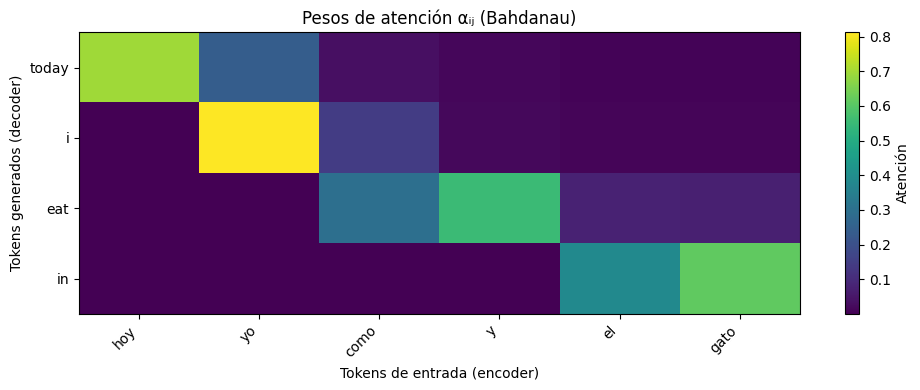

In [11]:
if attention_matrix is not None and attention_matrix.shape[0] > 0:
    plt.figure(figsize=(10, 4))
    plt.imshow(attention_matrix, aspect="auto")  # sin cmap explícito
    plt.xticks(
        ticks=range(len(input_tokens)),
        labels=input_tokens,
        rotation=45,
        ha="right",
    )
    plt.yticks(
        ticks=range(len(output_tokens)),
        labels=output_tokens,
    )
    plt.xlabel("Tokens de entrada (encoder)")
    plt.ylabel("Tokens generados (decoder)")
    plt.title("Pesos de atención αᵢⱼ (Bahdanau)")
    plt.colorbar(label="Atención")
    plt.tight_layout()
    plt.show()
else:
    print("No hay matriz de atención para visualizar.")

## 10. Interpretación de los resultados

En la matriz de atención se observa un alineamiento claro entre los tokens de entrada y los tokens
generados. Cada palabra de la secuencia de salida presta mayor atención a la palabra correspondiente
de la secuencia de entrada, lo que confirma que el mecanismo de atención ha aprendido una
alineación suave (*soft alignment*).

Este comportamiento concuerda con la formulación teórica de la atención de Bahdanau, donde el
vector de contexto se calcula como una combinación ponderada de las anotaciones del encoder.


## 11. Ejemplos adicionales de inferencia

Para verificar el funcionamiento del modelo en ambas direcciones, se muestran a continuación
dos ejemplos completos de inferencia:
- español → inglés
- inglés → español

Estos ejemplos confirman que el modelo es capaz de traducir correctamente en ambos sentidos
utilizando los checkpoints entrenados.


In [12]:
examples = [
    ("es-en", "yo estudio en casa"),
    ("en-es", "i study at home"),
]

for direction, sent in examples:
    path = f"seq2seq_bahdanau_{direction}.pt"
    model, src_vocab, trg_vocab, src_pad, sos, eos = load_checkpoint(path)

    out_toks, attn_mat, in_toks = translate_with_attention(
        model, src_vocab, trg_vocab, src_pad, sos, eos, sent
    )

    print("\n=== Example ===")
    print("Direction:", direction)
    print("Input :", sent)
    print("Output:", " ".join(out_toks))
    print("Attn shape:", attn_mat.shape)



=== Example ===
Direction: es-en
Input : yo estudio en casa
Output: i study at home
Attn shape: (4, 4)

=== Example ===
Direction: en-es
Input : i study at home
Output: yo estudio en casa
Attn shape: (4, 4)


## 12. Limitaciones del modelo

Aunque el modelo funciona correctamente sobre el dataset sintético, se observan algunas
limitaciones esperables en este tipo de arquitectura:

- Dependencia de un vocabulario cerrado.
- Errores de traducción cuando aparecen combinaciones poco frecuentes.
- Ausencia de mecanismos más avanzados como *beam search* o *copy mechanisms*.

Estas limitaciones no afectan al objetivo principal de la práctica, cuyo foco es el estudio
y la comprensión del mecanismo de atención de Bahdanau.
